In [2]:
import pyspark
from pyspark.sql.functions import *

spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [7]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Data Prep

In [3]:
df = spark.read.csv('case.csv', header=True, inferSchema=True)

# Rename column
df = df.withColumnRenamed('SLA_due_date', 'case_due_date')

# Convert to better data types
df = (
    df.withColumn('case_late', col('case_late') == 'YES')
    .withColumn('case_closed', col('case_closed') == 'YES')
)
df = df.withColumn('council_district', format_string('%04d', col('council_district')))
df = (
    df.withColumn('case_opened_date', to_timestamp(col('case_opened_date'), 'M/d/yy H:mm'))
    .withColumn('case_closed_date', to_timestamp(col('case_closed_date'), 'M/d/yy H:mm'))
    .withColumn('case_due_date', to_timestamp(col('case_due_date'), 'M/d/yy H:mm'))
)

# Cleanup text data
df = df.withColumn('request_address', lower(trim(col('request_address'))))
# Extract zipcode
df = df.withColumn('zipcode', regexp_extract(col('request_address'), r'\d+$', 0))

# Create a `case_lifetime` feature
df = (
    df.withColumn('case_age', datediff(current_timestamp(), 'case_opened_date'))
    .withColumn('days_to_closed', datediff('case_closed_date', 'case_opened_date'))
    .withColumn('case_lifetime', when(col('case_closed'), col('days_to_closed')).otherwise(col('case_age')))
    .drop('case_age', 'days_to_closed')
)

# Join departments and sources
depts = spark.read.csv('dept.csv', header=True, inferSchema=True)
sources = spark.read.csv('source.csv', header=True, inferSchema=True)

df = df.join(depts, 'dept_division', 'left').join(sources, 'source_id', 'left')

In [4]:
df.show(1, vertical=True)

-RECORD 0--------------------------------------
 source_id              | svcCRMLS             
 dept_division          | Field Operations     
 case_id                | 1014127332           
 case_opened_date       | 2018-01-01 00:42:00  
 case_closed_date       | 2018-01-01 12:29:00  
 case_due_date          | 2020-09-26 00:42:00  
 case_late              | false                
 num_days_late          | -998.5087616000001   
 case_closed            | true                 
 service_request_type   | Stray Animal         
 SLA_days               | 999.0                
 case_status            | Closed               
 request_address        | 2315  el paso st,... 
 council_district       | 0005                 
 zipcode                | 78207                
 case_lifetime          | 0                    
 dept_name              | Animal Care Services 
 standardized_dept_name | Animal Care Services 
 dept_subject_to_SLA    | YES                  
 source_username        | svcCRMLS      

# Exercise
How many different cases are there, by department?

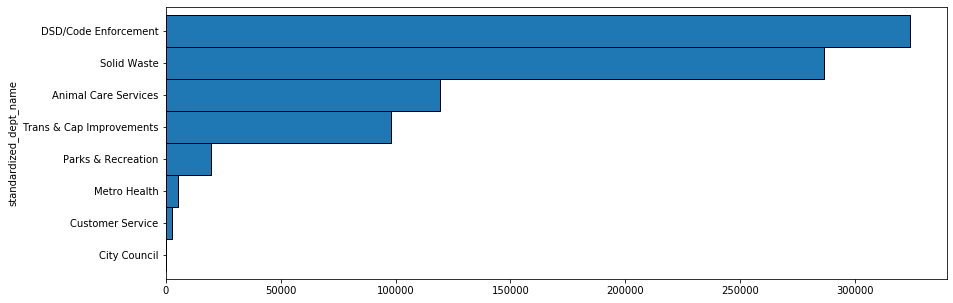

In [14]:
(
    df.groupBy("standardized_dept_name")
    .count()
    .toPandas()
    .set_index("standardized_dept_name")["count"]
    .sort_values()
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)



# Exercise
Does the percentage of cases that are late vary by department?

In [19]:
late_count = (
    df.where(col('case_late'))
    .groupBy("standardized_dept_name")
    .count()
    .toPandas()
    .set_index("standardized_dept_name")["count"]
)
late_count

standardized_dept_name
Solid Waste                 33729
Animal Care Services        23751
Trans & Cap Improvements     5529
Parks & Recreation           3810
Customer Service             2035
Metro Health                  854
DSD/Code Enforcement        26439
Name: count, dtype: int64

In [21]:
total_count = (
    df.groupBy("standardized_dept_name")
    .count()
    .toPandas()
    .set_index("standardized_dept_name")["count"]
)
total_count

standardized_dept_name
Solid Waste                 286287
Animal Care Services        119362
Trans & Cap Improvements     97841
Parks & Recreation           19964
Customer Service              2889
Metro Health                  5313
City Council                    34
DSD/Code Enforcement        323579
Name: count, dtype: int64

standardized_dept_name
Animal Care Services        0.198983
City Council                     NaN
Customer Service            0.704396
DSD/Code Enforcement        0.081708
Metro Health                0.160738
Parks & Recreation          0.190844
Solid Waste                 0.117815
Trans & Cap Improvements    0.056510
Name: count, dtype: float64


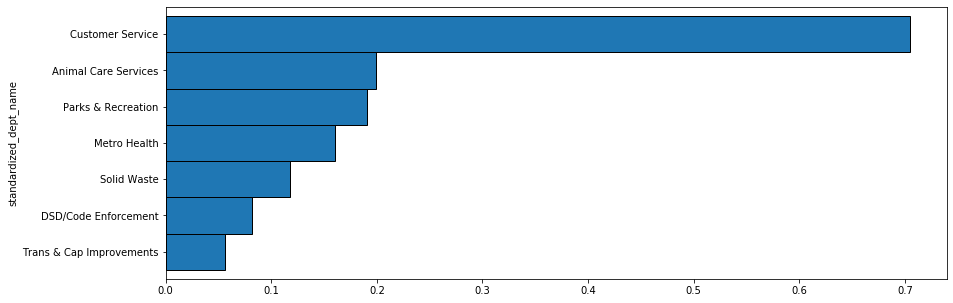

In [30]:
percentage_of_late_cases = late_count/total_count
(
    #city coucil has null value, so drop it
    percentage_of_late_cases.dropna()
    .sort_values()
    .plot.barh(width=1, edgecolor='black',figsize=(14, 5))
)
print(percentage_of_late_cases )

# Exercise
On average, how late are the late cases by department?

In [57]:
average_late_days = (
    df.where(col('case_late'))
    .groupBy("standardized_dept_name")
    .agg(mean('num_days_late').alias('average_late_days'))
    .toPandas()
    .set_index("standardized_dept_name")
    .sort_values(by ='average_late_days')
)

In [60]:
average_late_days

,average_late_days
standardized_dept_name,
Metro Health,6.494700
Solid Waste,7.147173
Trans & Cap Improvements,10.662950
Parks & Recreation,22.427807
Animal Care Services,23.446730
DSD/Code Enforcement,49.506340
Customer Service,88.182482


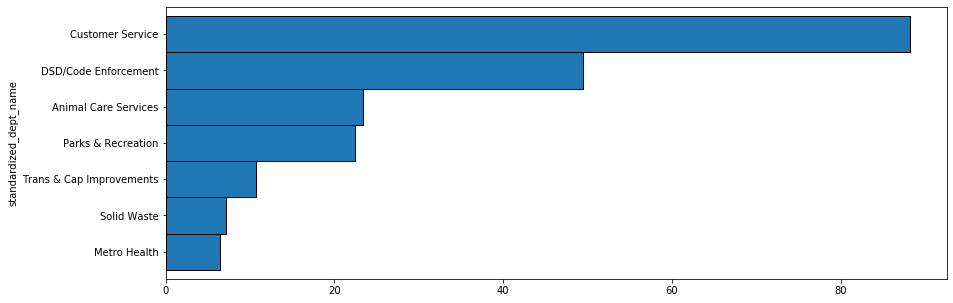

In [55]:
average_late_days.plot.barh(width=1, edgecolor='black',figsize=(14, 5))

# Exercise
What is the service type that is the most late? Just for Parks & Rec?

In [64]:
service_late_days = (
    df.where(col('case_late'))
    .groupBy("service_request_type")
    .agg(mean('num_days_late').alias('average_late_days'))
    .toPandas()
    .set_index("service_request_type")
    .sort_values(by ='average_late_days')
)

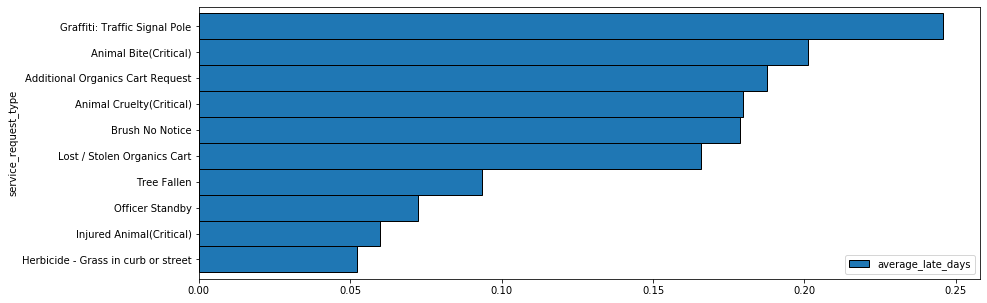

In [67]:
service_late_days[:10].plot.barh(width=1, edgecolor='black',figsize=(14, 5))

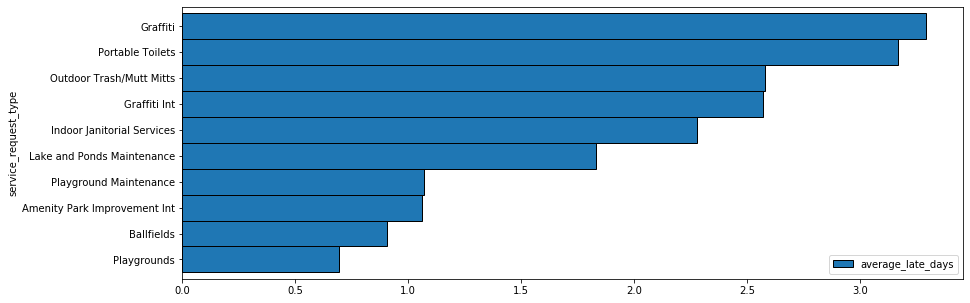

In [81]:
(
    df
    .where(col('case_late'))
    .where(col('standardized_dept_name') == 'Parks & Recreation')
    .groupBy("service_request_type")
    .agg(mean('num_days_late').alias('average_late_days'))
    .toPandas()
    .set_index("service_request_type")
    .sort_values(by ='average_late_days')[:10]
    .plot.barh(width=1, edgecolor='black',figsize=(14, 5))
)

# Exercise
For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

# Exercise
Does whether or not its a weekend matter for when a case is opened/closed?

In [82]:
df.show(1, vertical=True)

-RECORD 0--------------------------------------
 source_id              | svcCRMLS             
 dept_division          | Field Operations     
 case_id                | 1014127332           
 case_opened_date       | 2018-01-01 00:42:00  
 case_closed_date       | 2018-01-01 12:29:00  
 case_due_date          | 2020-09-26 00:42:00  
 case_late              | false                
 num_days_late          | -998.5087616000001   
 case_closed            | true                 
 service_request_type   | Stray Animal         
 SLA_days               | 999.0                
 case_status            | Closed               
 request_address        | 2315  el paso st,... 
 council_district       | 0005                 
 zipcode                | 78207                
 case_lifetime          | 0                    
 dept_name              | Animal Care Services 
 standardized_dept_name | Animal Care Services 
 dept_subject_to_SLA    | YES                  
 source_username        | svcCRMLS      

In [86]:
df.withColumn("is_weekend", when(dayofweek("case_opened_date").isin([1,5]).cast("int")).toPandas()

KeyboardInterrupt: 

# Exercise
On average, how many cases are opened a day for the Customer Service department?

# Exercise
Does the number of service requests for the solid waste department vary by day of the week?